In [107]:
%%capture
!pip install autora
!pip install autora[all-theorists]
!pip install autora[all-experimentalists]

# ADD YOUR GITHUB REPO LINK HERE
#!pip install git+https://github.com/acesmeci/autora-experimentalist-MAFT

In [108]:
# autora state
from autora.state import State, StandardState, on_state, estimator_on_state, Delta, VariableCollection

# experiment_runner
from autora.experiment_runner.synthetic.neuroscience.task_switching import task_switching

# experimentalist
from autora.experimentalist.grid import grid_pool
from autora.experimentalist.random import random_pool, random_sample
from autora.experimentalist.falsification import falsification_sample
from autora.experimentalist.model_disagreement import model_disagreement_sample
from autora.experimentalist.uncertainty import uncertainty_sample

# theorist
from autora.theorist.bms import BMSRegressor

# sklearn
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Optional, List


In [109]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

class PolynomialRegressor:
    """
    This theorist fits a polynomial function to the data.
    """

    def __init__(self, degree: int = 3):
      self.poly = PolynomialFeatures(degree=degree, include_bias=False)
      self.model = LinearRegression()

    def fit(self, x, y):
      features = self.poly.fit_transform(x, y)
      self.model.fit(features, y)
      return self

    def predict(self, x):
      features = self.poly.fit_transform(x)
      return self.model.predict(features)

    def print_eqn(self):
        # Extract the coefficients and intercept
        coeffs = self.model.coef_
        intercept = self.model.intercept_

        # Handle multi-output case by iterating over each output's coefficients and intercept
        if coeffs.ndim > 1:
            for idx in range(coeffs.shape[0]):
                equation = f"y{idx+1} = {intercept[idx]:.3f}"
                feature_names = self.poly.get_feature_names_out()
                for coef, feature in zip(coeffs[idx], feature_names):
                    equation += f" + ({coef:.3f}) * {feature}"
                print(equation)
        else:
            equation = f"y = {intercept:.3f}"
            feature_names = self.poly.get_feature_names_out()
            for coef, feature in zip(coeffs, feature_names):
                equation += f" + ({coef:.3f}) * {feature}"
            print(equation)



In [110]:
# SET UP STATE
# Here, we use a non-standard State to be able to use a multiple models
@dataclass(frozen=True)
class CustomState(State):
    variables: Optional[VariableCollection] = field(
        default=None, metadata={"delta": "replace"}
    )
    conditions: Optional[pd.DataFrame] = field(
        default=None, metadata={"delta": "replace", "converter": pd.DataFrame}
    )
    experiment_data: Optional[pd.DataFrame] = field(
        default=None, metadata={"delta": "extend", "converter": pd.DataFrame}
    )
    models_bms: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    models_lr: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    models_polyr: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    reference_conditions: Optional[pd.DataFrame] = field(
       default=None, metadata={"delta": "replace", "converter": pd.DataFrame}
    )


In [111]:
# state wrapper for all theorists
@on_state()
def theorists_on_state(experiment_data, variables, bms_epochs):

  # extract conditions X and observations y from experiment data
  ivs = [iv.name for iv in variables.independent_variables]
  dvs = [dv.name for dv in variables.dependent_variables]
  X = experiment_data[ivs]
  y = experiment_data[dvs]

  # initialize and fit theorists
  theorist_bms = BMSRegressor(epochs=bms_epochs)
  theorist_polyr = PolynomialRegressor()
  theorist_lr = linear_model.LinearRegression()

  return Delta(models_bms = [theorist_bms.fit(X, y)],
               models_lr=[theorist_lr.fit(X, y)],
               models_polyr=[theorist_polyr.fit(X, y)])

## our experimentalist

In [112]:
from autora.experimentalist.autora_experimentalist_example import sample

In [113]:
# state wrapper for grid pooler experimentalist (generates a grid of experiment conditions)
@on_state()
def grid_pool_on_state(variables):
  return Delta(conditions=grid_pool(variables))

# state wrapper for random pooler experimentalist (generates a pool of experiment conditions)
@on_state()
def random_pool_on_state(variables, num_samples, random_state=None):
  return Delta(conditions=random_pool(variables, num_samples, random_state))

# state wrapper for random experimentalist (samples experiment conditions from a set of conditions)
@on_state()
def random_sample_on_state(conditions, all_conditions, num_samples, random_state=None):
  return Delta(conditions=random_sample(all_conditions, num_samples, random_state))

# **** STATE WRAPPER FOR YOUR EXPERIMENTALIST ***
@on_state()
def custom_sample_on_state(#experiment_data,
                           conditions,
                           reference_conditions,
                           models_bms,models_lr,models_polyr,
                           all_conditions, #not necessarily needed
                           num_samples=1,
                           step = 0,
                           max_steps = 0, ##Choose this wisely
                           random_state=None):

  # fixed epsilon works well with the improved sampler (scaling + greedy max–min)
  #epsilon = 0.01 
  denom = max(1, max_steps)
  epsilon = min(0.01, 0.3 * (1 - step / denom))  # (kept for reference) ## This is the annealing thing I added for now

  new_conditions = sample(
      conditions=conditions,
      reference_conditions=reference_conditions,
      num_samples=num_samples,
      epsilon=epsilon,
      random_state=random_state
  )

  return Delta(conditions=new_conditions)

In [114]:
# state wrapper for synthetic experiment runner
@on_state()
def run_experiment_on_state(conditions, experiment_runner):
  data = experiment_runner.run(conditions=conditions, added_noise=0.0)
  return Delta(experiment_data=data)

In [115]:
# the following function is used to compute the model performance
# on the validation set in terms of mean squared error
def get_validation_MSE(validation_experiment_data, working_state):
    ivs = [iv.name for iv in validation_experiment_data.variables.independent_variables]
    dvs = [dv.name for dv in validation_experiment_data.variables.dependent_variables]
    X = validation_experiment_data.experiment_data[ivs]
    y = validation_experiment_data.experiment_data[dvs]

    y_pred_bms = working_state.models_bms[-1].predict(X)
    y_pred_lr = working_state.models_lr[-1].predict(X)
    y_pred_polyr = working_state.models_polyr[-1].predict(X)

    MSE_bms = ((y - y_pred_bms)**2).mean()[0]
    MSE_lr = ((y - y_pred_lr)**2).mean()[0]
    MSE_polyr = ((y - y_pred_polyr)**2).mean()[0]

    min_MSE = min(MSE_bms, MSE_lr, MSE_polyr)

    return min_MSE

In [116]:
def run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner, sim=0):

  # VALIDATION STATE
  # at every step of our discovery process, we will evaluate the performance
  # of the theorist against the ground truth. Here, we will define the ground
  # truth as a grid of data points sampled across the domain of the experimental
  # design space. We will store this validation set in a separate validation states

  # create AutoRA state for validation purposes
  validation_conditions = CustomState(variables=experiment_runner.variables)
  validation_experiment_data = CustomState(variables=experiment_runner.variables)

  # our validation set will be consist of a grid of experiment conditons
  # across the entire experimental design domain
  validation_conditions = grid_pool_on_state(validation_conditions)
  validation_experiment_data = grid_pool_on_state(validation_experiment_data)
  validation_experiment_data = run_experiment_on_state(validation_experiment_data, experiment_runner=experiment_runner)


  benchmark_MSE_log = list()
  working_MSE_log = list()

  # INITIAL STATE
  # We begin our discovery experiment with randomly sampled data set for 10
  # conditions. We will use the same state for each experimentalist method.

  # create initial AutoRA state which we will use for our discovery expeirments
  initial_state = CustomState(variables=experiment_runner.variables)

  # we will initiate our discovery process with 10 randomly sampled experiment conditions
  initial_state = random_pool_on_state(initial_state,
                                      num_samples=num_initial_conditions,
                                      random_state = sim)

  # we obtain the corresponding experiment data
  initial_state = run_experiment_on_state(initial_state, experiment_runner=experiment_runner)

  # initialize benchmark state for random experimentalist
  benchmark_state = CustomState(**initial_state.__dict__)

  # initialize working state for your custom experimentalist
  working_state = CustomState(**initial_state.__dict__)

  # for each discovery cycle
  for cycle in range(num_cycles):

    print("SIMULATION " + str(sim)  + " / DISCOVERY CYCLE " + str(cycle))

    # first, we fit a model to the data
    print("Fitting models on benchmark state...")
    benchmark_state = theorists_on_state(benchmark_state, bms_epochs=bms_epochs)
    print("Fitting models on working state...")
    working_state = theorists_on_state(working_state, bms_epochs=bms_epochs)

    # now we can determine how well the models do on the validation set
    benchmark_MSE = get_validation_MSE(validation_experiment_data, benchmark_state)
    benchmark_MSE_log.append(benchmark_MSE)

    working_MSE = get_validation_MSE(validation_experiment_data, working_state)
    working_MSE_log.append(working_MSE)

    # then we determine the next experiment condition
    print("Sampling new experiment conditions...")
    benchmark_state = random_sample_on_state(benchmark_state,
                                              all_conditions=validation_conditions.conditions,
                                              num_samples=num_conditions_per_cycle)
    working_state = custom_sample_on_state(working_state,
                                           reference_conditions=validation_conditions.conditions,
                                           all_conditions=validation_conditions.conditions,
                                           num_samples=num_conditions_per_cycle,
                                           step=cycle,
                                           max_steps=num_cycles)
    
    print("Obtaining observations...")
    # we obtain the corresponding experiment data
    benchmark_state = run_experiment_on_state(benchmark_state, experiment_runner=experiment_runner)
    working_state = run_experiment_on_state(working_state, experiment_runner=experiment_runner)

  return benchmark_MSE_log, working_MSE_log, benchmark_state, working_state

In [117]:
# meta parameters

# DO NOT CHANGE THESE PARAMETERS
num_cycles = 20
num_conditions_per_cycle = 1
num_initial_conditions = 1

# YOU MAY CHANGE THESE PARAMETERS
num_discovery_simulations = 10
bms_epochs = 100 # Note, to speed things up, you can set bms_epochs = 10 or even bms_epochs = 1 (this will lead to poor performance of the BMS regressor but the other two theorists will still fit)

In [130]:
# setting experiment runner and theorist
experiment_runner = task_switching()

# run simulation
benchmark_MSE_log, working_MSE_log, benchmark_state, working_state = run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner)

INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 0 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.52it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 66.65it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.10it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 58.55it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.41it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 55.74it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.51it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 54.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 54.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 52.68it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 51.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 51.28it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 54.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.65it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 38.08it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 47.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.62it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.90it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.70it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 38.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.30it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 37.81it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 44.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 43.85it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 45.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 40.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.33it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 34.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 47.57it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.28it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 44.41it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.52it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 51.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 35.74it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


    cur_task_strength  alt_task_strength  is_switch  cur_task_performance
0                0.86               0.64          1              0.592120
1                0.36               0.10          0              0.943747
2                0.18               0.40          0              0.749668
3                0.34               0.20          1              0.672809
4                0.70               0.88          0              0.644239
5                0.04               0.54          1              0.656472
6                0.42               0.40          0              0.811090
7                0.80               0.76          1              0.539788
8                0.16               0.48          1              0.593342
9                0.94               1.00          1              0.506623
10               0.98               0.90          1              0.537072
11               0.22               0.06          0              0.939314
12               0.42               0.

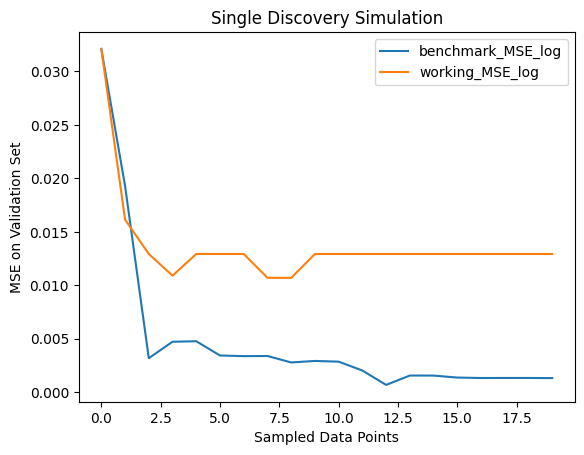

In [129]:
# lets plot the benchmark_MSE_log and the workign_MSE_log
plt.plot(benchmark_MSE_log, label='benchmark_MSE_log')
plt.plot(working_MSE_log, label='working_MSE_log')
plt.xlabel('Sampled Data Points')
plt.ylabel('MSE on Validation Set')
plt.title('Single Discovery Simulation')
plt.legend()

# we can also investigate the final state more closely
# for example, these are all the experimental data collected
# under random sampling:
print(benchmark_state.experiment_data)
# and for your custom experimentalist
print(working_state.experiment_data)

In [120]:
# meta parameters

# DO NOT CHANGE THESE PARAMETERS
np.random.seed(42)
num_cycles = 20
num_conditions_per_cycle = 1
num_initial_conditions = 1
num_discovery_simulations = 10
bms_epochs = 100

# setting experiment runner and theorist
experiment_runner = task_switching()

benchmark_MSE_plot_data = np.zeros([num_discovery_simulations, num_cycles])
working_MSE_plot_data = np.zeros([num_discovery_simulations, num_cycles])

for sim in range(num_discovery_simulations):
  benchmark_MSE_log, working_MSE_log, benchmark_state, working_state = run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner, sim)

  benchmark_MSE_plot_data[sim, :] = benchmark_MSE_log
  working_MSE_plot_data[sim, :] = working_MSE_log

INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 0 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 62.10it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 59.86it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 58.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.15it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 55.09it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 62.24it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 46.64it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.67it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 54.23it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.43it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 51.11it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.43it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 49.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 42.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 49.30it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.95it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 48.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.31it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 49.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 38.12it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.70it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.61it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 49.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.06it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 46.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 42.98it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.58it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 44.37it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 58.96it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 60.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 58.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 51.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.42it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 53.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:01<00:00, 58.49it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 55.45it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 55.86it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 53.70it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 53.09it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 50.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.90it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 50.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 53.23it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.81it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 52.96it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 47.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 42.58it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 39.02it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.16it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 49.12it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 50.12it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 54.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 37.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.77it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.43it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 44.62it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 63.64it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.24it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 58.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.15it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 54.65it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 62.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 46.87it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 52.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.77it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 53.15it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.07it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 46.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.70it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 43.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.24it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 44.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 46.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 62.41it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 50.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.76it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.87it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 49.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 48.42it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.70it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 50.52it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 50.43it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 49.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 54.23it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.96it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 39.67it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 51.44it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.43it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.73it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 49.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 50.70it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 43.52it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 63.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 63.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.60it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.85it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 50.61it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.24it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 53.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.56it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 49.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 54.55it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 40.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 51.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 51.31it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.28it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 49.65it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.72it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 50.33it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.58it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.64it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 54.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 46.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 54.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 53.23it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 48.30it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.82it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 39.70it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.52it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.97it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.43it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.20it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 42.59it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 54.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 39.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 51.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 50.26it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.13it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 63.16it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.60it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 53.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 56.73it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 54.61it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 52.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.33it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 44.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.68it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 56.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.10it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 48.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.90it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 43.05it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.82it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 44.09it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:01<00:00, 56.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 41.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.68it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 43.45it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 63.49it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.07it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 46.16it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 45.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 43.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.55it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 50.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.81it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 43.09it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.72it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 40.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.65it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.74it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.86it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 63.10it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 54.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 58.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.02it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 60.58it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.87it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 55.08it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.16it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 59.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.44it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 57.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.49it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 61.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.10it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 51.68it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 51.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 53.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 54.90it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.26it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 39.72it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 49.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.28it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.14it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.20it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.45it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 46.33it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 38.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.60it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 40.37it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.73it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 46.23it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 51.42it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.74it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.82it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 58.88it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 48.81it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 61.85it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 55.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 51.61it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 53.32it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.76it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 56.23it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 50.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 56.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.02it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 51.48it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 50.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 50.45it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 41.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 47.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 49.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 50.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 52.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 48.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.94it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 41.44it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 44.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.81it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 45.65it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.51it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 48.13it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.19it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 44.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 60.08it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.52it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 57.59it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 54.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 54.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 58.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.86it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 55.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 55.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.58it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 43.42it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 51.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 47.49it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 48.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.02it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 48.44it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 43.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 46.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 46.97it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.60it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 44.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 43.45it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 44.00it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 50.81it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.00it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.62it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 50.43it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 46.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.31it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 60.37it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:01<00:00, 58.09it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 58.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 57.55it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 55.62it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.74it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 52.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.90it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 40.31it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.76it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 48.02it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 53.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.72it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 52.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.09it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 46.60it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 49.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 43.15it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.59it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 52.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.73it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 34.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.82it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 48.31it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 40.94it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.71it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:13<00:00,  7.60it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 100/100 [00:14<00:00,  7.11it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:05<00:00, 18.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 100/100 [00:06<00:00, 16.48it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:35<00:00,  2.81it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 50.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:07<00:00, 13.58it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 42.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:03<00:00, 31.14it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 35.30it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 38.71it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:04<00:00, 24.21it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 100/100 [00:03<00:00, 30.08it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:03<00:00, 28.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 100/100 [00:27<00:00,  3.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 41.13it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 100/100 [00:04<00:00, 22.19it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:04<00:00, 22.87it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 100/100 [00:03<00:00, 31.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:03<00:00, 26.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 100/100 [00:12<00:00,  7.86it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 40.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 100/100 [00:04<00:00, 21.62it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:16<00:00,  6.12it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 42.00it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:04<00:00, 24.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 34.07it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:03<00:00, 31.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 40.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 41.12it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 46.13it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 35.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 34.87it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 100/100 [00:05<00:00, 17.65it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [03:49<00:00,  2.30s/it]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 100/100 [00:04<00:00, 22.24it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:03<00:00, 32.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 49.18it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 41.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 38.71it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 46.76it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 52.43it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 38.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 40.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 39.15it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


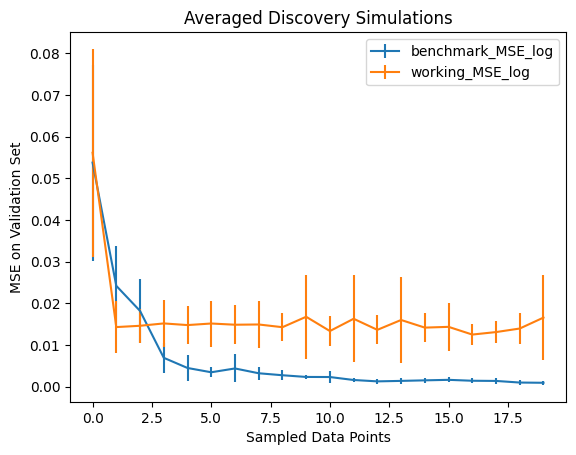

In [121]:
# plot the data with standard error
plt.errorbar(np.arange(num_cycles), np.mean(benchmark_MSE_plot_data, axis=0), yerr=np.std(benchmark_MSE_plot_data, axis=0), label='benchmark_MSE_log')
plt.errorbar(np.arange(num_cycles), np.mean(working_MSE_plot_data, axis=0), yerr=np.std(working_MSE_plot_data, axis=0), label='working_MSE_log')
plt.xlabel('Sampled Data Points')
plt.ylabel('MSE on Validation Set')
plt.title('Averaged Discovery Simulations')
plt.legend()

In [122]:
print(np.sum(np.mean(working_MSE_plot_data, axis=0)))

0.3349256196296257


In [123]:
np.mean(working_MSE_plot_data, axis=0)


array([0.05613153, 0.0142986 , 0.01461208, 0.01517685, 0.0147798 ,
       0.01515607, 0.01486539, 0.01492332, 0.01427141, 0.01677338,
       0.01334878, 0.01629234, 0.01363546, 0.01600207, 0.01417225,
       0.0143532 , 0.01250416, 0.01310013, 0.01395296, 0.01657583])